In [3]:
#!pip install seaborn


     |████████████████████████████████| 288 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 411 kB/s eta 0:00:01    |████████████████▉               | 6.4 MB 3.4 MB/s eta 0:00:02
     |████████████████████████████████| 498 kB 11.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
# !pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2935 sha256=d9db14ea853d149e9e3c32a7350431a79e962b47e5e52012d999173a8e0a5785
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
# !pip install scikit-learn

     |████████████████████████████████| 9.7 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 33.8 MB 6.1 MB/s eta 0:00:011    |███████▉                        | 8.3 MB 12.7 MB/s eta 0:00:03
     |████████████████████████████████| 297 kB 8.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import time
import seaborn as sns
import sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
!pwd

/tf/notebooks


In [10]:
batch_size = 128 #the largest, the smaller the noise
img_height = 224
img_width = 224

In [11]:
#tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (224, 224)) # Resizing the image to 224x224 dimention
    return (image, label)


In [12]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/tf/notebooks/Database2',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 4551 files belonging to 2 classes.
Using 3641 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='/tf/notebooks/Database2',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4551 files belonging to 2 classes.
Using 910 files for validation.


In [14]:
type(val_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [15]:
class_names = train_ds.class_names
print(class_names)

['COVID-19', 'Normal']


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().map(scale_resize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().map(scale_resize_image, num_parallel_calls=AUTOTUNE)

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Basic CNN Adam

In [22]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model1.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

In [24]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [25]:
epochs=25
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
29/29 [==============================] - 22s 406ms/step - loss: 0.3296 - accuracy: 0.8992 - val_loss: 0.0729 - val_accuracy: 0.9703
Epoch 2/25
29/29 [==============================] - 2s 58ms/step - loss: 0.0503 - accuracy: 0.9810 - val_loss: 0.1144 - val_accuracy: 0.9593
Epoch 3/25
29/29 [==============================] - 2s 58ms/step - loss: 0.0483 - accuracy: 0.9830 - val_loss: 0.0404 - val_accuracy: 0.9857
Epoch 4/25
29/29 [==============================] - 2s 58ms/step - loss: 0.0318 - accuracy: 0.9904 - val_loss: 0.0329 - val_accuracy: 0.9901
Epoch 5/25
29/29 [==============================] - 2s 58ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0353 - val_accuracy: 0.9901
Epoch 6/25
29/29 [==============================] - 2s 59ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0446 - val_accuracy: 0.9824
Epoch 7/25
29/29 [==============================] - 2s 59ms/step - loss: 0.0153 - accuracy: 0.9945 - val_loss: 0.0367 - val_accuracy: 0.9923
Epoch 8/25


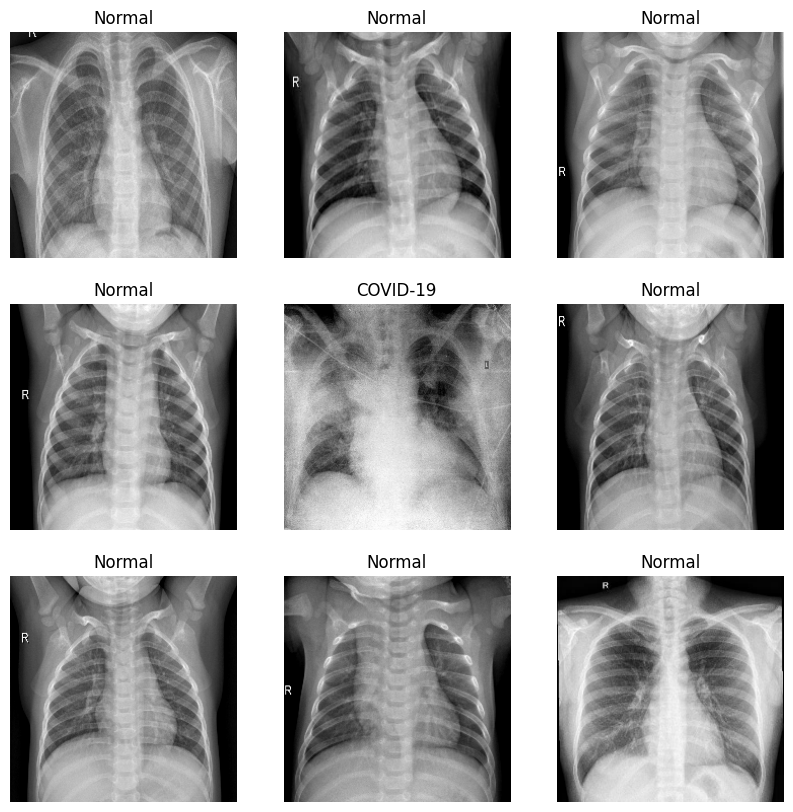

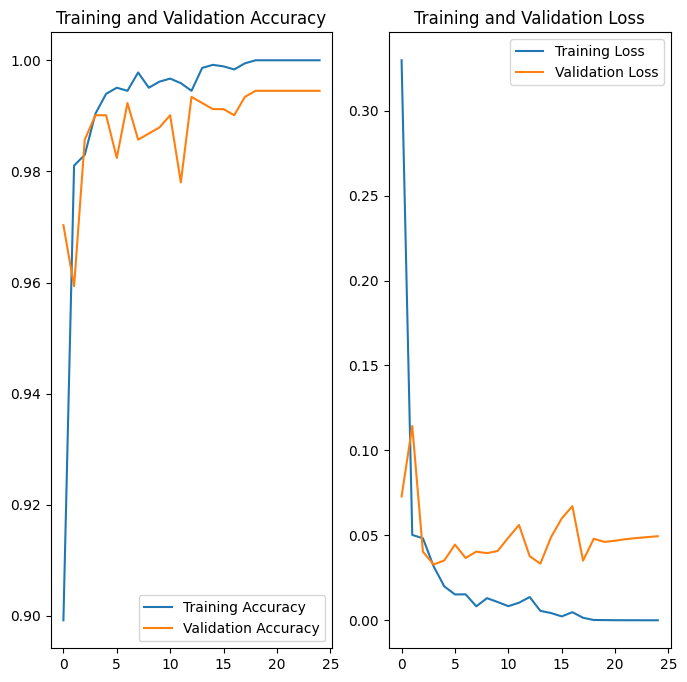

In [26]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
print(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [28]:
y_pred1 = []  # store predicted labels
y_true1 = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true1.append(label_batch)
   # compute predictions
   preds = model1.predict(image_batch)
   # append predicted labels
   y_pred1.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels1 = tf.concat([item for item in y_true1], axis = 0)
predicted_labels1 = tf.concat([item for item in y_pred1], axis = 0)

1/1 [==============================] - 0s 46ms/step


In [29]:
cm1 = confusion_matrix(correct_labels1, predicted_labels1)
print(cm1)

[[234   5]
 [  0 671]]


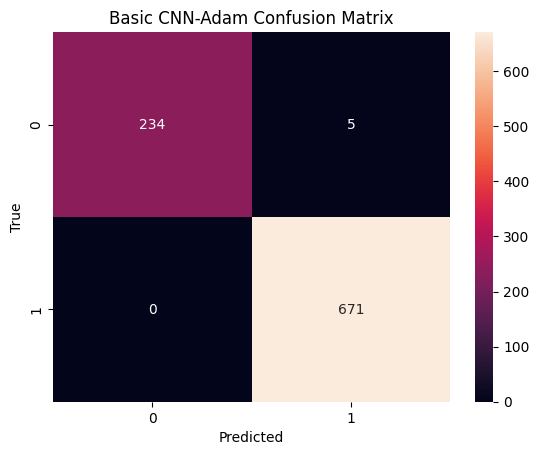

In [30]:
ax= plt.subplot()
sns.heatmap(cm1,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Basic CNN-Adam Confusion Matrix'); 
plt.show()

In [31]:
print(classification_report(correct_labels1, predicted_labels1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       239
           1       0.99      1.00      1.00       671

    accuracy                           0.99       910
   macro avg       1.00      0.99      0.99       910
weighted avg       0.99      0.99      0.99       910



In [32]:
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9790794979079498
Specificity :  1.0


# Basic CNN Adam with data augmentation 

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [35]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [36]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [37]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [38]:
epochs = 25
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
29/29 [==============================] - 76s 3s/step - loss: 0.7669 - accuracy: 0.7317 - val_loss: 0.1912 - val_accuracy: 0.9462
Epoch 2/25
29/29 [==============================] - 71s 2s/step - loss: 0.1416 - accuracy: 0.9541 - val_loss: 0.0970 - val_accuracy: 0.9659
Epoch 3/25
29/29 [==============================] - 71s 2s/step - loss: 0.0877 - accuracy: 0.9695 - val_loss: 0.0930 - val_accuracy: 0.9659
Epoch 4/25
29/29 [==============================] - 70s 2s/step - loss: 0.0834 - accuracy: 0.9695 - val_loss: 0.0707 - val_accuracy: 0.9725
Epoch 5/25
29/29 [==============================] - 71s 2s/step - loss: 0.0780 - accuracy: 0.9742 - val_loss: 0.0690 - val_accuracy: 0.9769
Epoch 6/25
29/29 [==============================] - 72s 2s/step - loss: 0.0645 - accuracy: 0.9780 - val_loss: 0.0654 - val_accuracy: 0.9725
Epoch 7/25
29/29 [==============================] - 71s 2s/step - loss: 0.0763 - accuracy: 0.9753 - val_loss: 0.0538 - val_accuracy: 0.9769
Epoch 8/25
29/29 [==

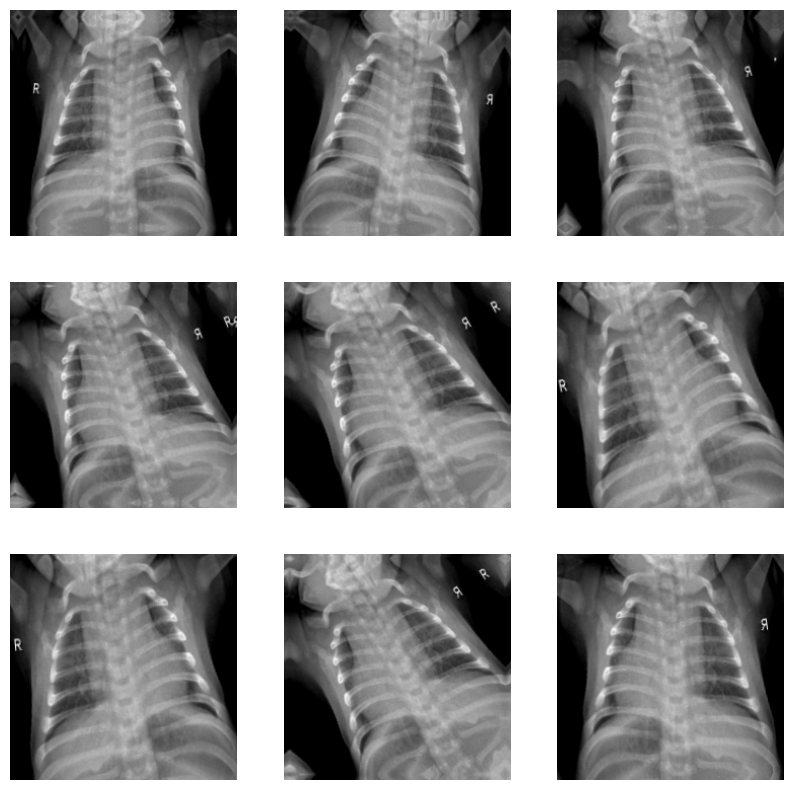

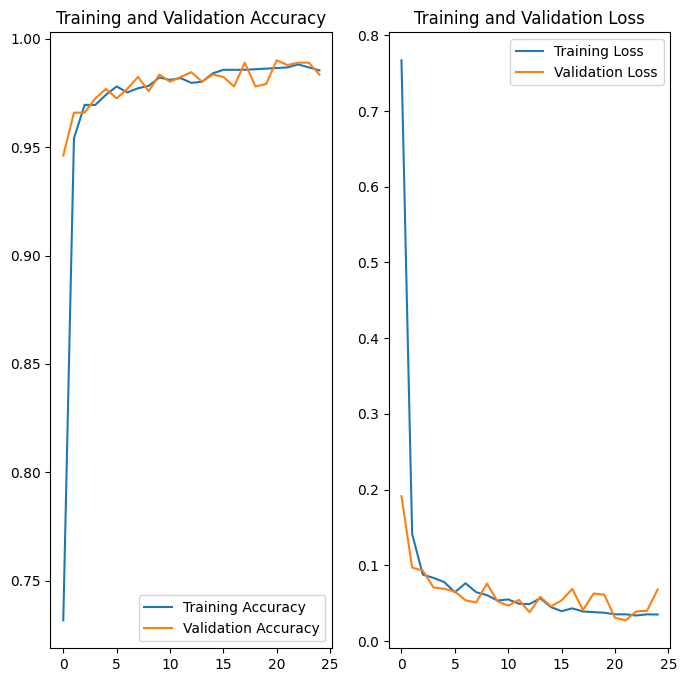

In [39]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
print(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [41]:
y_pred2 = []  # store predicted labels
y_true2 = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true2.append(label_batch)
   # compute predictions
   preds = model2.predict(image_batch)
   # append predicted labels
   y_pred2.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels2 = tf.concat([item for item in y_true2], axis = 0)
predicted_labels2 = tf.concat([item for item in y_pred2], axis = 0)

1/1 [==============================] - 0s 46ms/step


In [42]:
cm2 = confusion_matrix(correct_labels2, predicted_labels2)
print(cm2)

[[224  15]
 [  0 671]]


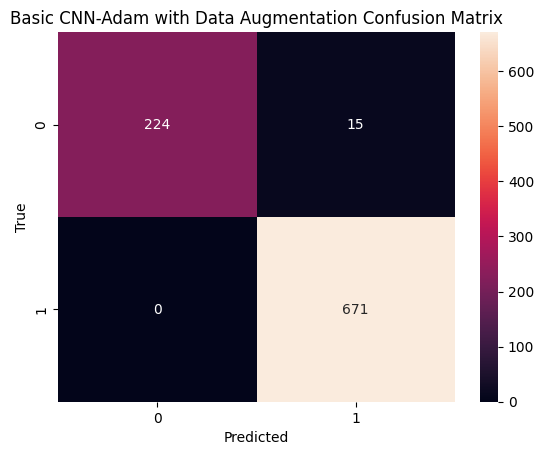

In [43]:
ax= plt.subplot()
sns.heatmap(cm2,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Basic CNN-Adam with Data Augmentation Confusion Matrix'); 
plt.show()

In [44]:
print(classification_report(correct_labels2, predicted_labels2))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       239
           1       0.98      1.00      0.99       671

    accuracy                           0.98       910
   macro avg       0.99      0.97      0.98       910
weighted avg       0.98      0.98      0.98       910



In [45]:
sensitivity1 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9372384937238494
Specificity :  1.0


# Implementing AlexNet SGD

In [46]:
model3 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [47]:
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                      

In [48]:
epochs = 25
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
29/29 [==============================] - 6s 106ms/step - loss: 1.0161 - accuracy: 0.8789 - val_loss: 0.5318 - val_accuracy: 0.7396
Epoch 2/25
29/29 [==============================] - 2s 67ms/step - loss: 0.0709 - accuracy: 0.9742 - val_loss: 0.2815 - val_accuracy: 0.9538
Epoch 3/25
29/29 [==============================] - 2s 68ms/step - loss: 0.0526 - accuracy: 0.9821 - val_loss: 0.2840 - val_accuracy: 0.9363
Epoch 4/25
29/29 [==============================] - 2s 67ms/step - loss: 0.0411 - accuracy: 0.9863 - val_loss: 0.2135 - val_accuracy: 0.9560
Epoch 5/25
29/29 [==============================] - 2s 68ms/step - loss: 0.0289 - accuracy: 0.9887 - val_loss: 0.1511 - val_accuracy: 0.9659
Epoch 6/25
29/29 [==============================] - 2s 67ms/step - loss: 0.0268 - accuracy: 0.9912 - val_loss: 0.1008 - val_accuracy: 0.9835
Epoch 7/25
29/29 [==============================] - 2s 68ms/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.0447 - val_accuracy: 0.9956
Epoch 8/25
2

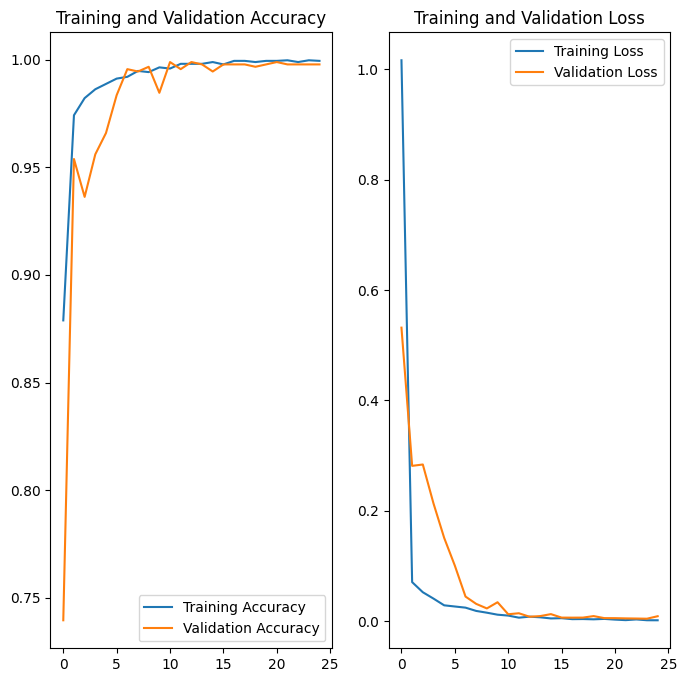

In [49]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
print(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [51]:
y_pred3 = []  # store predicted labels
y_true3 = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true3.append(label_batch)
   # compute predictions
   preds = model3.predict(image_batch)
   # append predicted labels
   y_pred3.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels3 = tf.concat([item for item in y_true3], axis = 0)
predicted_labels3 = tf.concat([item for item in y_pred3], axis = 0)

1/1 [==============================] - 0s 90ms/step


In [52]:
cm3 = confusion_matrix(correct_labels3, predicted_labels3)
print(cm3)

[[237   2]
 [  0 671]]


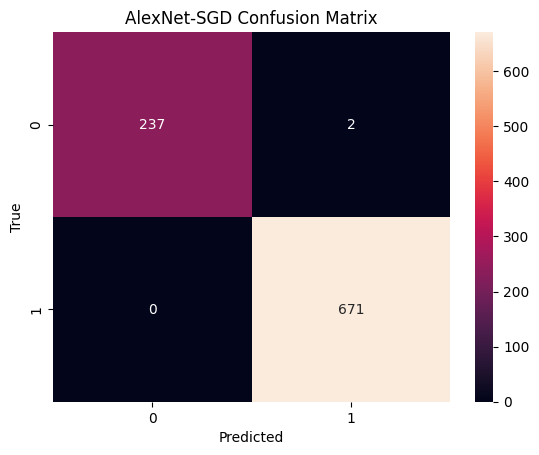

In [53]:
ax= plt.subplot()
sns.heatmap(cm3,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('AlexNet-SGD Confusion Matrix'); 
plt.show()

In [54]:
print(classification_report(correct_labels3, predicted_labels3))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       239
           1       1.00      1.00      1.00       671

    accuracy                           1.00       910
   macro avg       1.00      1.00      1.00       910
weighted avg       1.00      1.00      1.00       910



In [55]:
sensitivity1 = cm3[0,0]/(cm3[0,0]+cm3[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm3[1,1]/(cm3[1,0]+cm3[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9916317991631799
Specificity :  1.0


# Implementing AlexNet SGD with Data Augmentation

In [56]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [90]:
model4 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [92]:
model4.compile(loss=tf.keras.losses.BinaryCrossentropy(),, optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_20 (Bat  (None, 54, 54, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_21 (Bat  (None, 26, 26, 256)      1024      
 chNormalization)                                                
                                                      

In [93]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
new_ds = train_ds.concatenate(aug_ds)

In [94]:
epochs = 25
history4 = model4.fit(
  new_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
58/58 [==============================] - 14s 216ms/step - loss: 0.5425 - accuracy: 0.9144 - val_loss: 0.3361 - val_accuracy: 0.8275
Epoch 2/25
58/58 [==============================] - 13s 235ms/step - loss: 0.1181 - accuracy: 0.9650 - val_loss: 0.2709 - val_accuracy: 0.9593
Epoch 3/25
58/58 [==============================] - 14s 252ms/step - loss: 0.0611 - accuracy: 0.9789 - val_loss: 0.1749 - val_accuracy: 0.9582
Epoch 4/25
58/58 [==============================] - 14s 248ms/step - loss: 0.0646 - accuracy: 0.9769 - val_loss: 0.0858 - val_accuracy: 0.9879
Epoch 5/25
58/58 [==============================] - 13s 229ms/step - loss: 0.0509 - accuracy: 0.9824 - val_loss: 0.1040 - val_accuracy: 0.9747
Epoch 6/25
58/58 [==============================] - 13s 220ms/step - loss: 0.0470 - accuracy: 0.9838 - val_loss: 0.0575 - val_accuracy: 0.9835
Epoch 7/25
58/58 [==============================] - 12s 218ms/step - loss: 0.0363 - accuracy: 0.9870 - val_loss: 0.3880 - val_accuracy: 0.8769

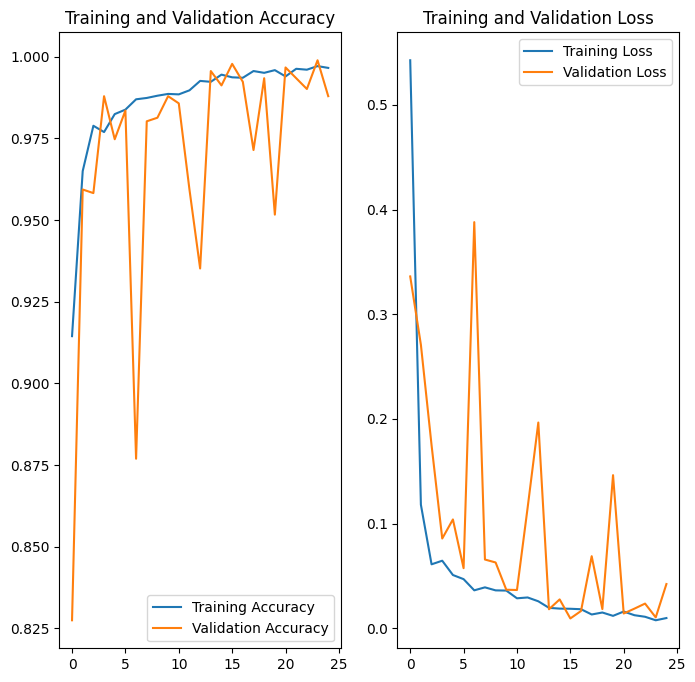

In [96]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [97]:
print(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [102]:
y_pred4 = []  # store predicted labels
y_true4 = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true4.append(label_batch)
   # compute predictions
   preds = model4.predict(image_batch)
   # append predicted labels
   y_pred4.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels4 = tf.concat([item for item in y_true4], axis = 0)
predicted_labels4 = tf.concat([item for item in y_pred4], axis = 0)

1/1 [==============================] - 0s 16ms/step


In [99]:
cm4 = confusion_matrix(correct_labels4, predicted_labels4)
print(cm4)

[[228  11]
 [  0 671]]


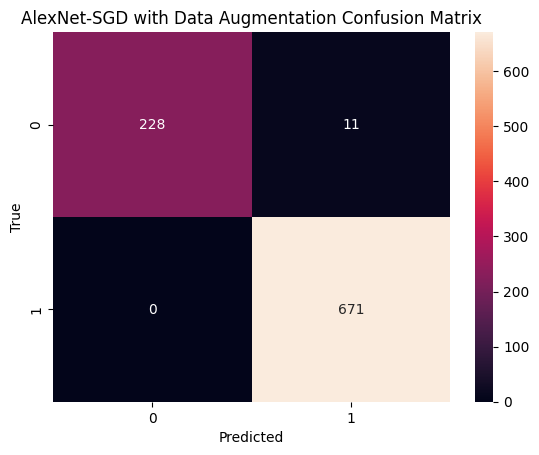

In [100]:
ax= plt.subplot()
sns.heatmap(cm4,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('AlexNet-SGD with Data Augmentation Confusion Matrix'); 
plt.show()

In [101]:
print(classification_report(correct_labels4, predicted_labels4))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       239
           1       0.98      1.00      0.99       671

    accuracy                           0.99       910
   macro avg       0.99      0.98      0.98       910
weighted avg       0.99      0.99      0.99       910



In [103]:
sensitivity1 = cm4[0,0]/(cm4[0,0]+cm4[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm4[1,1]/(cm4[1,0]+cm4[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9539748953974896
Specificity :  1.0


# Implementing AlexNet Adam

In [134]:
model5 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [334]:
model5.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_40 (Bat  (None, 54, 54, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_41 (Bat  (None, 26, 26, 256)      1024      
 chNormalization)                                                
                                                     

In [137]:
epochs = 25
history5 = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
29/29 [==============================] - 5s 73ms/step - loss: 5.5308 - accuracy: 0.8377 - val_loss: 1890.4932 - val_accuracy: 0.7374
Epoch 2/25
29/29 [==============================] - 2s 73ms/step - loss: 0.1990 - accuracy: 0.9591 - val_loss: 85.3283 - val_accuracy: 0.6945
Epoch 3/25
29/29 [==============================] - 2s 73ms/step - loss: 0.1007 - accuracy: 0.9679 - val_loss: 20.0562 - val_accuracy: 0.5286
Epoch 4/25
29/29 [==============================] - 2s 71ms/step - loss: 0.0692 - accuracy: 0.9791 - val_loss: 15.8479 - val_accuracy: 0.4374
Epoch 5/25
29/29 [==============================] - 2s 69ms/step - loss: 0.0622 - accuracy: 0.9756 - val_loss: 11.7469 - val_accuracy: 0.5121
Epoch 6/25
29/29 [==============================] - 2s 71ms/step - loss: 0.0462 - accuracy: 0.9846 - val_loss: 0.8751 - val_accuracy: 0.8637
Epoch 7/25
29/29 [==============================] - 2s 73ms/step - loss: 0.0396 - accuracy: 0.9863 - val_loss: 0.2743 - val_accuracy: 0.9484
Epoch 

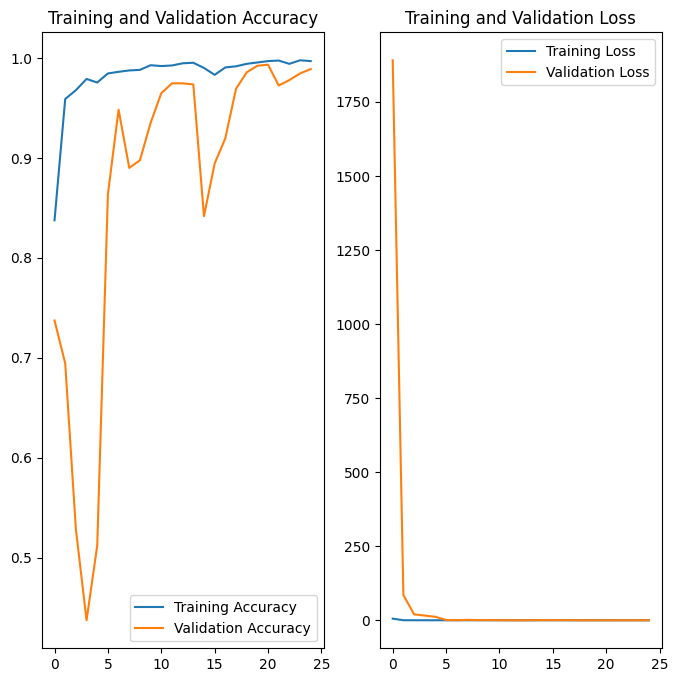

In [138]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [139]:
print(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [142]:
y_pred5 = []  # store predicted labels
y_true5 = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true5.append(label_batch)
   # compute predictions
   preds = model5.predict(image_batch)
   # append predicted labels
   y_pred5.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels5 = tf.concat([item for item in y_true5], axis = 0)
predicted_labels5 = tf.concat([item for item in y_pred5], axis = 0)

1/1 [==============================] - 0s 19ms/step


In [143]:
cm5 = confusion_matrix(correct_labels5, predicted_labels5)
print(cm5)

[[238   1]
 [  9 662]]


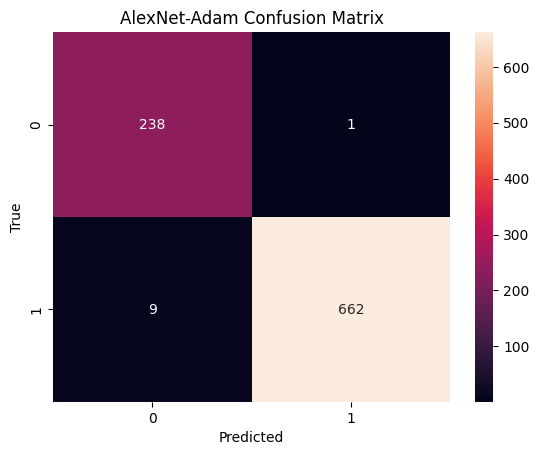

In [144]:
ax= plt.subplot()
sns.heatmap(cm5,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('AlexNet-Adam Confusion Matrix'); 
plt.show()

In [145]:
print(classification_report(correct_labels5, predicted_labels5))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       239
           1       1.00      0.99      0.99       671

    accuracy                           0.99       910
   macro avg       0.98      0.99      0.99       910
weighted avg       0.99      0.99      0.99       910



In [146]:
sensitivity1 = cm5[0,0]/(cm5[0,0]+cm5[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm5[1,1]/(cm5[1,0]+cm5[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.99581589958159
Specificity :  0.9865871833084948


# Implementing AlexNet Adam with Data Augmentation

In [78]:
# Implementing AlexNet Adam

In [166]:
model6 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [167]:
model6.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model6.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_55 (Bat  (None, 54, 54, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_56 (Bat  (None, 26, 26, 256)      1024      
 chNormalization)                                                
                                                     

In [168]:
epochs = 25
history6 = model6.fit(
  new_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
58/58 [==============================] - 14s 207ms/step - loss: 2.2230 - accuracy: 0.9061 - val_loss: 161.1905 - val_accuracy: 0.3934
Epoch 2/25
58/58 [==============================] - 12s 207ms/step - loss: 0.2264 - accuracy: 0.9615 - val_loss: 9.1632 - val_accuracy: 0.5714
Epoch 3/25
58/58 [==============================] - 12s 208ms/step - loss: 0.1409 - accuracy: 0.9699 - val_loss: 1.6583 - val_accuracy: 0.7505
Epoch 4/25
58/58 [==============================] - 12s 210ms/step - loss: 0.1076 - accuracy: 0.9765 - val_loss: 0.3448 - val_accuracy: 0.9495
Epoch 5/25
58/58 [==============================] - 13s 224ms/step - loss: 0.0684 - accuracy: 0.9794 - val_loss: 0.7243 - val_accuracy: 0.8033
Epoch 6/25
58/58 [==============================] - 13s 226ms/step - loss: 0.1577 - accuracy: 0.9787 - val_loss: 0.1795 - val_accuracy: 0.9264
Epoch 7/25
58/58 [==============================] - 12s 214ms/step - loss: 0.0486 - accuracy: 0.9838 - val_loss: 0.0305 - val_accuracy: 0.99

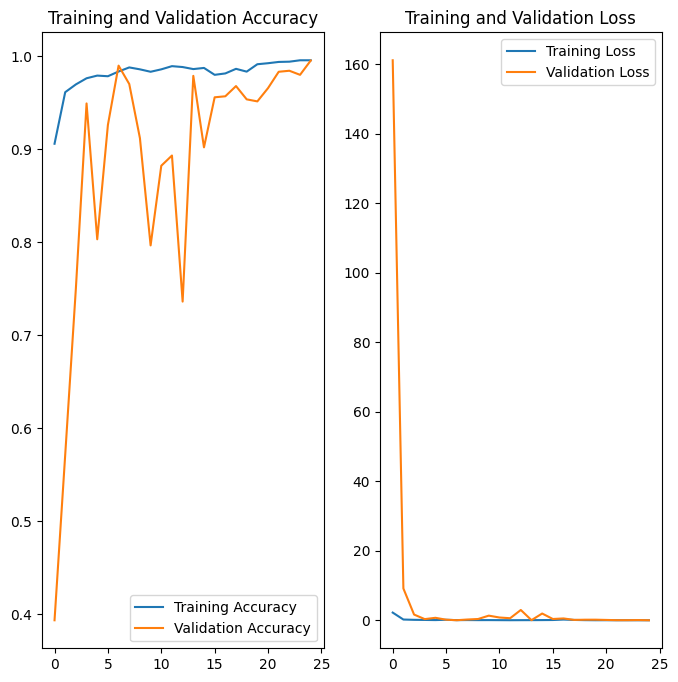

In [169]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [170]:
print(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [171]:
y_pred6 = []  # store predicted labels
y_true6 = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true6.append(label_batch)
   # compute predictions
   preds = model6.predict(image_batch)
   # append predicted labels
   y_pred6.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels6 = tf.concat([item for item in y_true6], axis = 0)
predicted_labels6 = tf.concat([item for item in y_pred6], axis = 0)

1/1 [==============================] - 0s 81ms/step


In [172]:
cm6 = confusion_matrix(correct_labels6, predicted_labels6)
print(cm6)

[[237   2]
 [  2 669]]


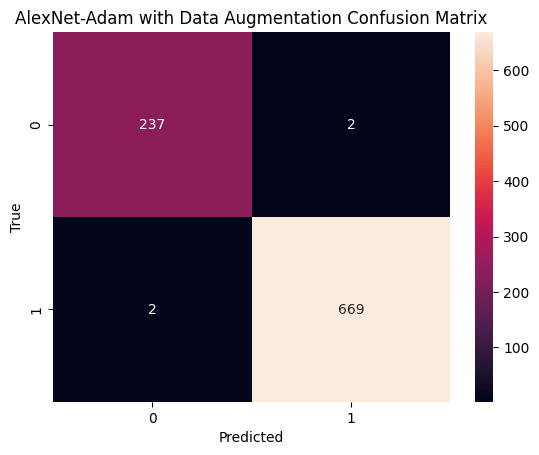

In [173]:
ax= plt.subplot()
sns.heatmap(cm6,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('AlexNet-Adam with Data Augmentation Confusion Matrix'); 
plt.show()

In [174]:
print(classification_report(correct_labels6, predicted_labels6))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       239
           1       1.00      1.00      1.00       671

    accuracy                           1.00       910
   macro avg       0.99      0.99      0.99       910
weighted avg       1.00      1.00      1.00       910



In [175]:
sensitivity1 = cm6[0,0]/(cm6[0,0]+cm6[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm6[1,1]/(cm6[1,0]+cm6[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9916317991631799
Specificity :  0.9970193740685543


# ROC Curve for models

In [213]:
from sklearn.metrics import roc_curve, auc

In [294]:
plt.figure(0).clf()

In [295]:
#model1 bCNN-adam
fpr, tpr, threshold = roc_curve(correct_labels1, predicted_labels1, pos_label=1)
plt.plot(fpr,tpr,label="Basic CNN-Adam, AUC="+str(auc(fpr,tpr)))


In [296]:
#model2 bcnn-adam da
fpr, tpr, threshold = roc_curve(correct_labels2, predicted_labels2, pos_label=1)
plt.plot(fpr,tpr,label="Basic CNN-Adam with DA, AUC="+str(auc(fpr,tpr)))


In [297]:
#model3 AN-SGD
fpr, tpr, threshold = roc_curve(correct_labels3, predicted_labels3, pos_label=1)
plt.plot(fpr,tpr,label="AlexNet-SGD, AUC="+str(auc(fpr,tpr)))


In [298]:
#model4 AN-SGD da
fpr, tpr, threshold = roc_curve(correct_labels4, predicted_labels4, pos_label=1)
plt.plot(fpr,tpr,label="AlexNet-SGD with DA, AUC="+str(auc(fpr,tpr)))


In [299]:
#model5 AN-adam
fpr, tpr, threshold = roc_curve(correct_labels5, predicted_labels5, pos_label=1)
plt.plot(fpr,tpr,label="AlexNet-Adam, AUC="+str(auc(fpr,tpr)))


In [300]:
#model6 AN-adam da
fpr, tpr, threshold = roc_curve(correct_labels6, predicted_labels6, pos_label=1)
plt.plot(fpr,tpr,label=r"$\bf{AlexNet-Adam with DA}$, AUC="+str(auc(fpr,tpr)))
plt.legend()

# roc_auc = auc(fpr,tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([-0.01, 1.0])
# plt.ylim([0.0, 1.01])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('AlexNet-Adam with DA ROC Curve')
# plt.legend(loc="lower right")
# plt.show()

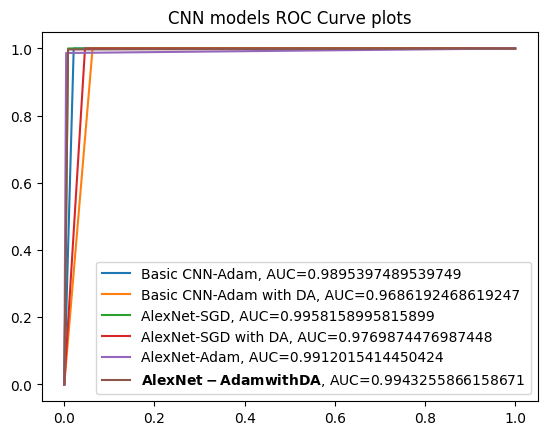

In [301]:
plt.title("CNN models ROC Curve plots")
plt.show()

# Visualise Neural Network

In [187]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [188]:
import visualkeras
from PIL import ImageFont

In [192]:
!pwd

/tf/notebooks


In [193]:
!ls

 AlexNet_Adam_DA					 Database
 DMML2-Basic+CNNDA_AlexNetSSGD+DA_AlexNetAdam+DA.ipynb	 Database2
 DMML2_CA.ipynb						 OpenSans-Medium.ttf
 DarkCovidNet-Copy1.ipynb				 fastai
 DarkCovidNet.ipynb					'logs\fit\'


In [357]:
font = ImageFont.truetype('/tf/notebooks/OpenSans-Medium.ttf', 40, encoding='unic')
font2 = ImageFont.truetype('/tf/notebooks/OpenSans-Medium.ttf', 25, encoding='unic')
font3 = ImageFont.truetype('/tf/notebooks/OpenSans-Medium.ttf', 70, encoding='unic')
font4 = ImageFont.truetype('/tf/notebooks/OpenSans-Medium.ttf', 20, encoding='unic')


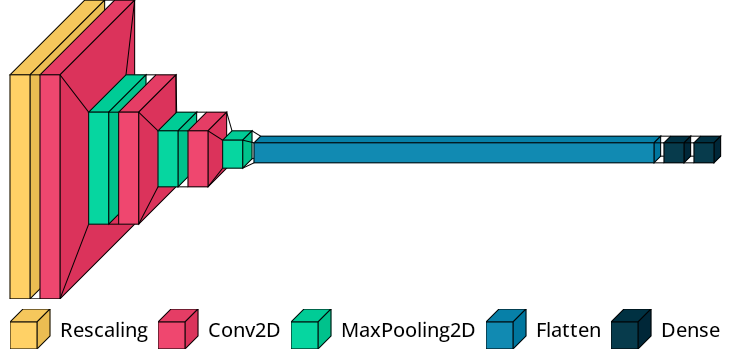

In [342]:
visualkeras.layered_view(model1, font=font4, scale_xy=1 , scale_z=0.1, legend=True)

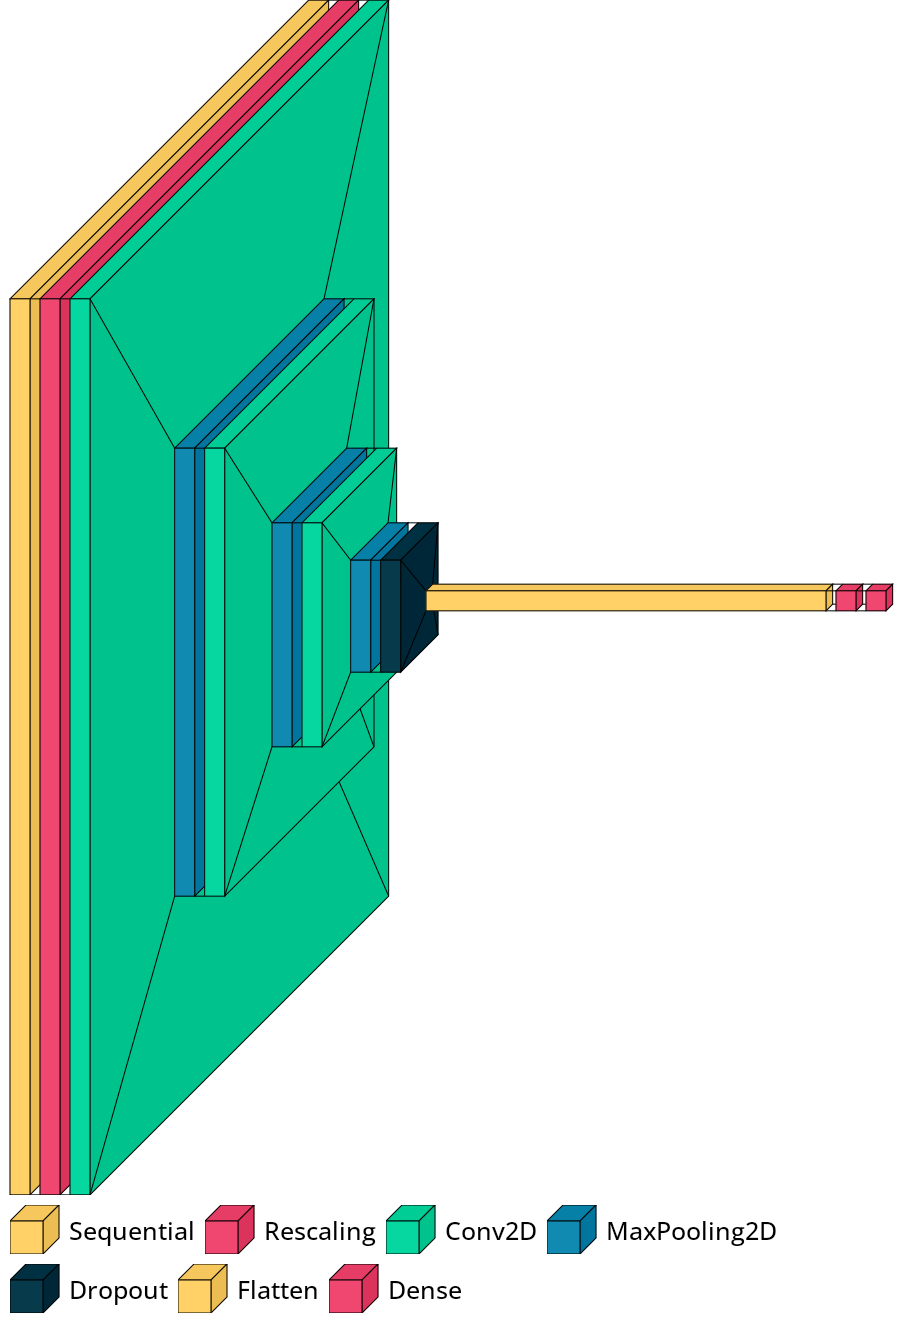

In [340]:
visualkeras.layered_view(model2, font=font2, legend=True)

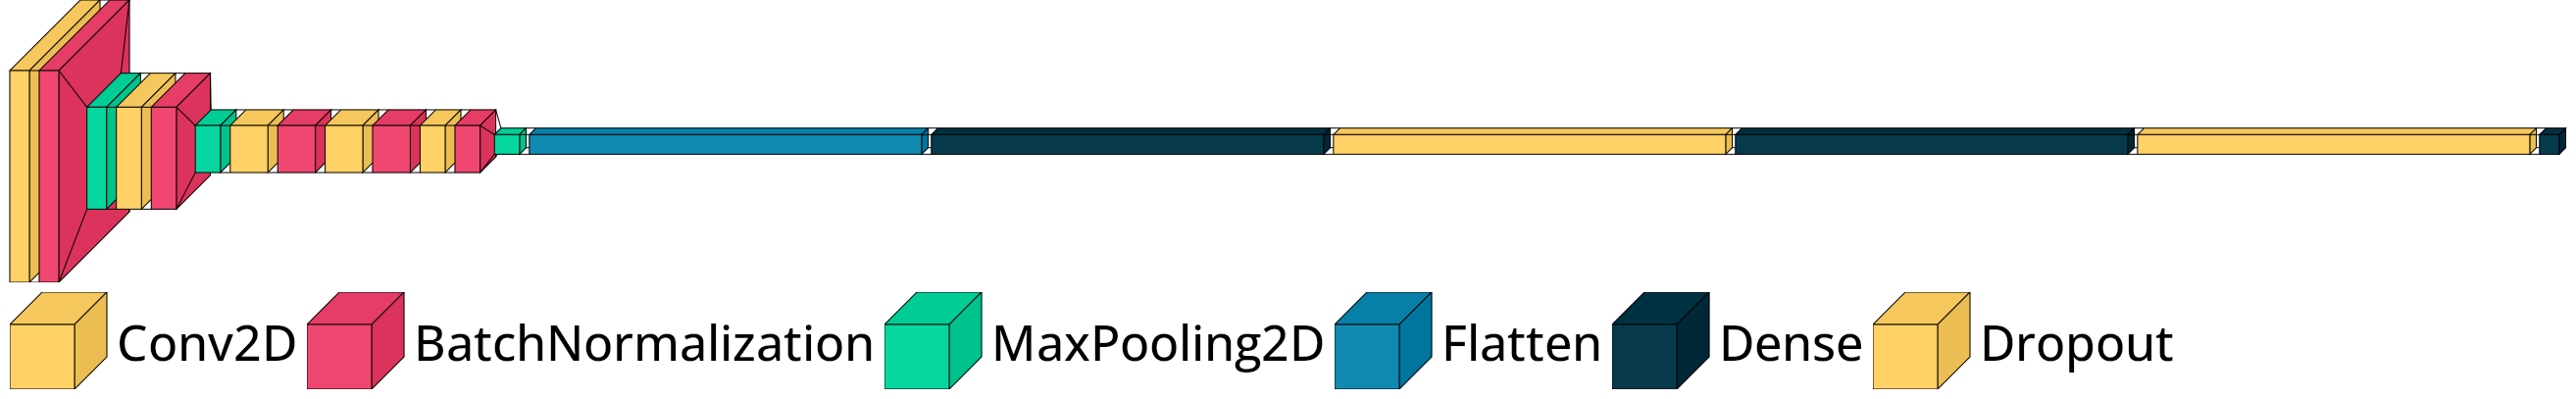

In [332]:
visualkeras.layered_view(model3, font=font3, scale_xy=4 , scale_z=0.1, legend=True)

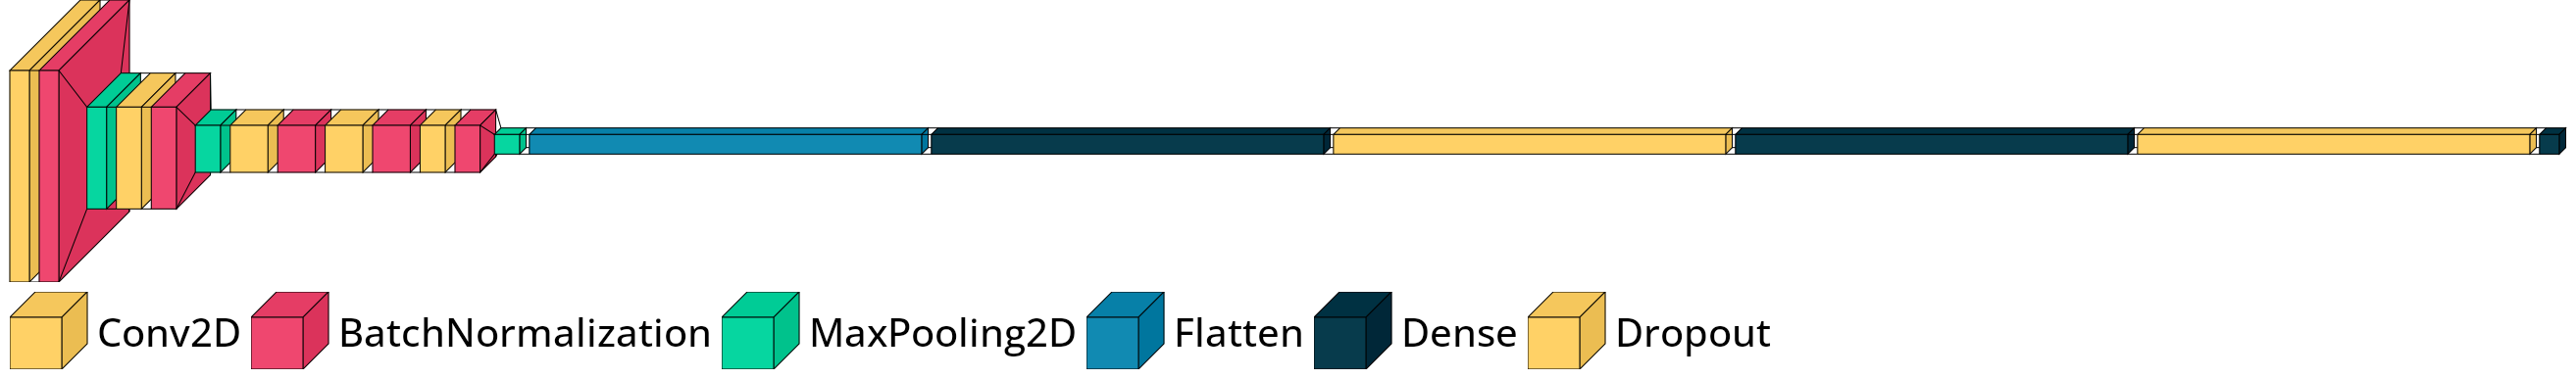

In [312]:
visualkeras.layered_view(model3, font=font, legend=True)

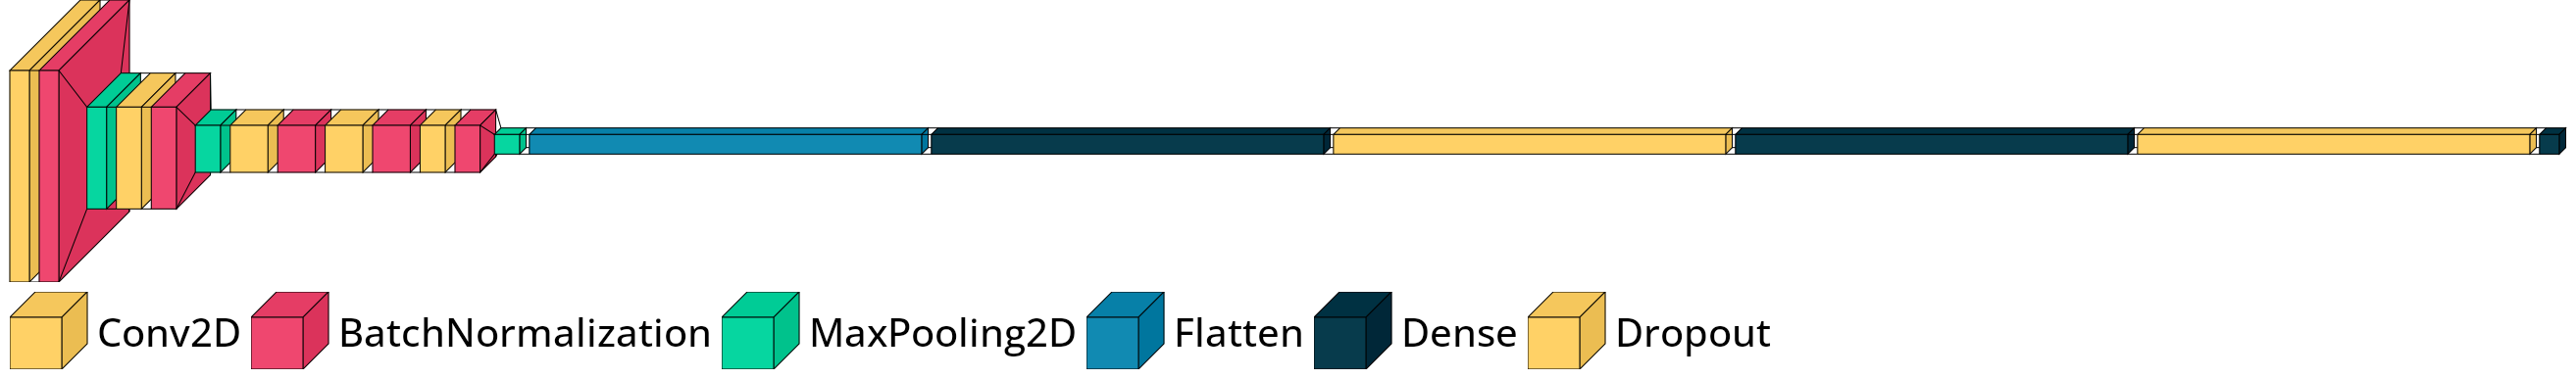

In [306]:
visualkeras.layered_view(model4, font=font, legend=True)

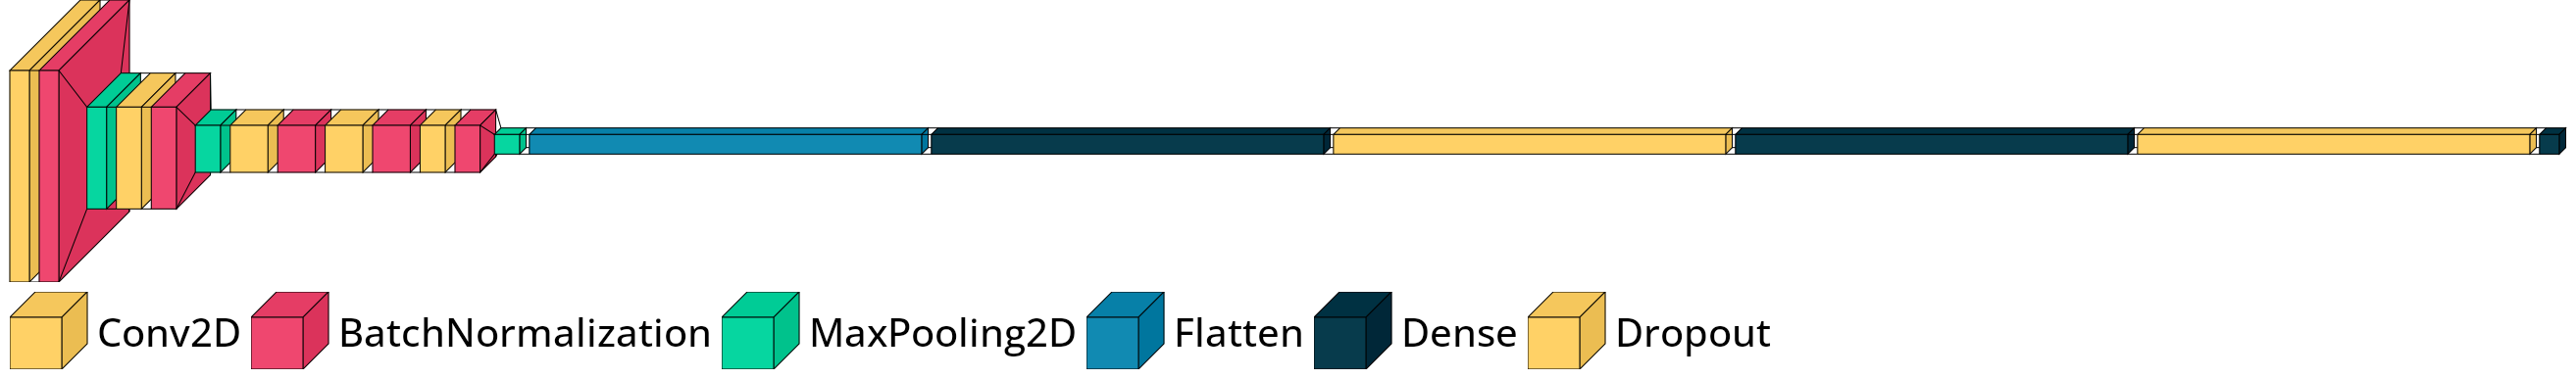

In [307]:
visualkeras.layered_view(model5, font=font, legend=True)

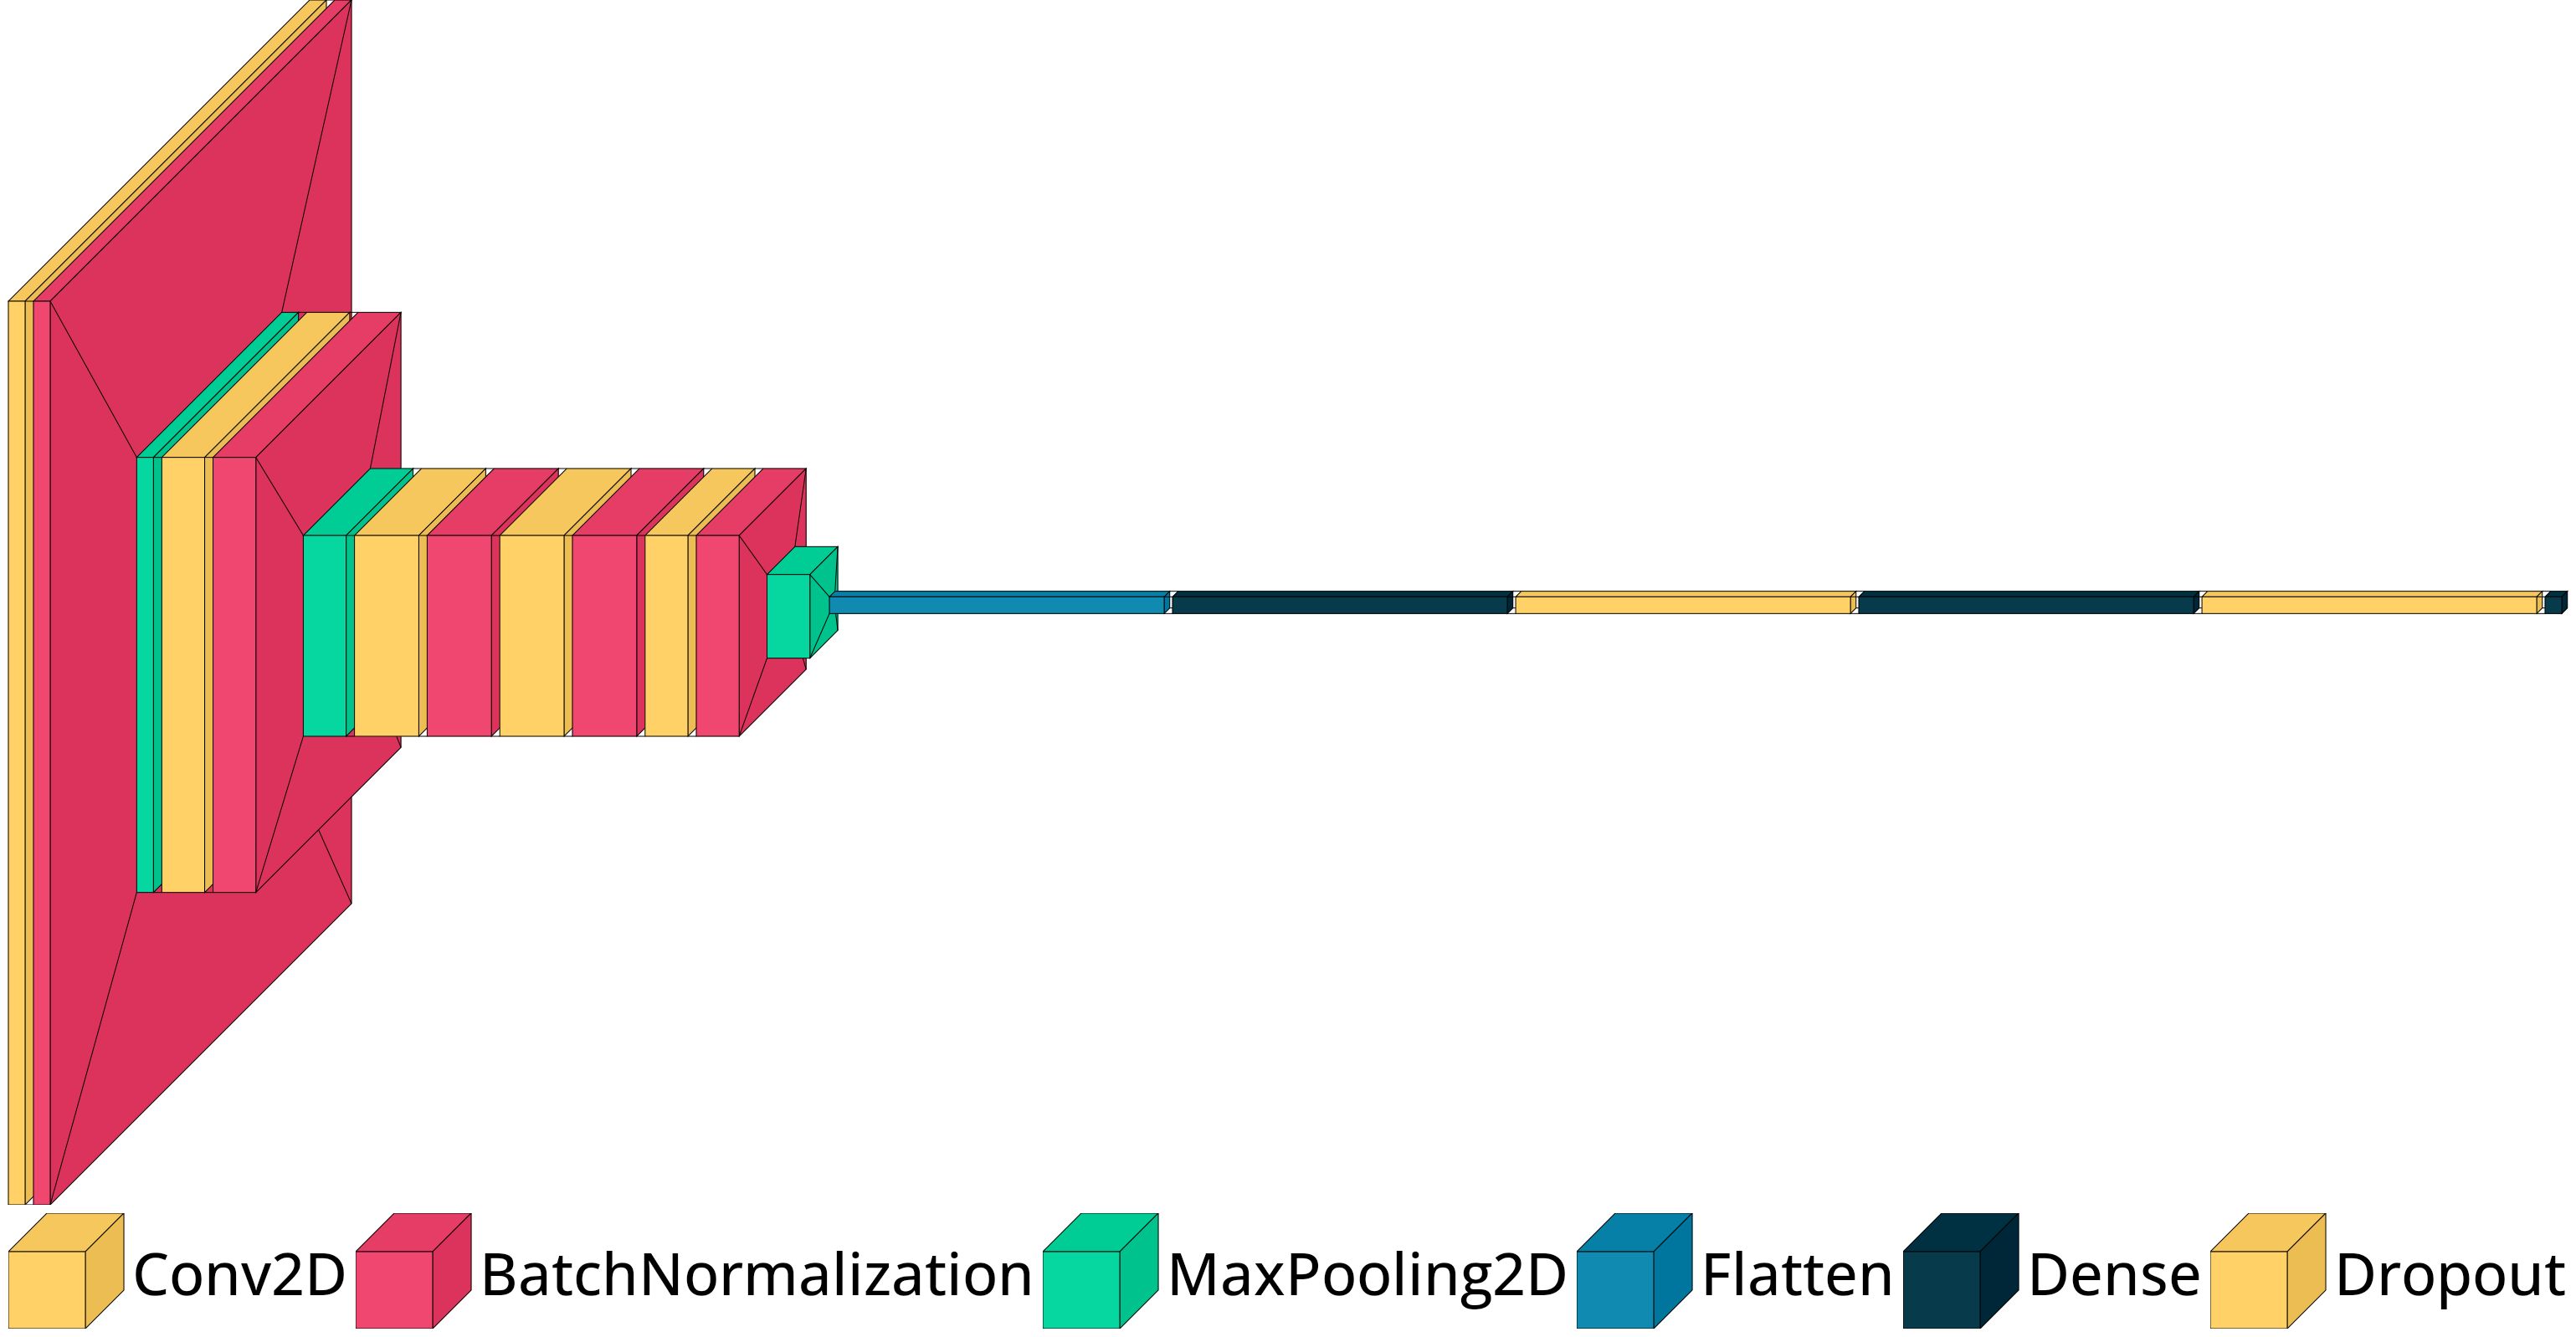

In [358]:
visualkeras.layered_view(model6, font=font3, scale_xy=20, scale_z=0.2, legend=True)

# References


"Convolutional Neural Network (CNN) | TensorFlow Core." TensorFlow. https://www.tensorflow.org/tutorials/images/cnn 
(accessed Dec. 10, 2022).

"Image classification | TensorFlow Core." TensorFlow. 
https://www.tensorflow.org/tutorials/images/classification (accessed 
Dec. 10, 2022).

R. Alake. "Implementing AlexNet CNN Architecture Using 
TensorFlow 2.0+ and Keras." Medium. 
https://towardsdatascience.com/implementing-alexnet-cnnarchitecture-using-tensorflow-2-0-and-keras-2113e090ad98 (accessed Dec. 10, 2022)